In [1]:
# load data
import dataloader
batch_size = 4
trainloader ,evalloader, testloader ,X_train, X_eval, X_test, y_train, y_eval, y_test , inputFeatures, outputFeatures, datasetName, features_names= dataloader.load_kaggle_diabetes_dataset(batch_size=batch_size)
from sklearn.datasets import load_breast_cancer

print(features_names)
#data = load_breast_cancer()
#features_names = data.feature_names
#print(data)

/home/rosario/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


8
train:shuffel = False
eval:shuffel = False
Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age'],
      dtype='object')


In [2]:
import train
import modelClass
import torch
from torch import nn
model= modelClass.BinaryClassification0HL16N(inputFeatures= inputFeatures, outputFeatures= outputFeatures)
num_epochs = 5
device = "cpu" #"cuda:0"
doEval = False
lr = 0.001
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),lr=lr)
train.train(trainloader, model, num_epochs, device, y_train,loss_function, optimizer)


Epoch: 0
      Training_acc: 0.36807817589576547
-------------------



/home/rosario/.local/lib/python3.10/site-packages/torch/autograd/__init__.py:197: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:109.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch: 1
      Training_acc: 0.5879478827361564
-------------------

Epoch: 2
      Training_acc: 0.6530944625407166
-------------------

Epoch: 3
      Training_acc: 0.6514657980456026
-------------------

Epoch: 4
      Training_acc: 0.6482084690553745
-------------------

NOTE: THESE SAVED MODELS ARE BEEING OVERWRITTEN ON NEXT RUN


In [3]:
import numpy as np
X_train = np.array(X_train)
import lime 
import lime.lime_tabular

np.random.seed(1)
explainer = lime.lime_tabular.LimeTabularExplainer(X_train, feature_names=features_names, class_names=['0', '1'])

#dirPath = utils.createDirPath(seed , modelName, datasetName, num_epochs, batch_size, lr)

#print("evaluating ...")
#loaderList = [trainloader,evalloader,testloader]
#nameList = ["train","eval", "test"]
#yList = [y_train, y_eval,y_test]
#print(explainer)
#eval.doALLeval(model, modelsDirPath,dirPath, loaderList, device,optimizer, loss_function, num_epochs, nameList, yList, inputFeatures)


In [4]:
import utils

#featureListAll  = utils.unpackingFeatureList(inputFeatures , grads)

data = utils.loadData("./NEWtest/Results/seedNum_0_BinaryClassification0HL16N_KaggleDiabetesALL_Num_Epochs_3batchSize_4_0.1_2023-03-19_145845/")
#for i in data:
#   print(i)
gradientsPerFeature = data["trainGradientsPerFeature"]
print(np.max(gradientsPerFeature))
print(np.min(gradientsPerFeature))


0.9856257438659668
-1.079402208328247


In [5]:
from mlxtend.frequent_patterns import apriori, association_rules
import torch 
import numpy as np
from Myhelper_func import *
from tqdm import tqdm

#import shap

predsList_eval = []
with torch.no_grad():
        
        for inputs,labels in evalloader:
        
            inputs = inputs.to(device)
            labels = labels.to(device)  
    
            outputs = model(inputs)
            #print(outputs)
            __, preds = torch.max(outputs, 1)
            predsList_eval.extend(preds.cpu())
#print(len(predsList_eval))  

predsList_test = []
with torch.no_grad():
        
        for inputs,labels in testloader:
        
            inputs = inputs.to(device)
            labels = labels.to(device)  
    
            outputs = model(inputs)
            #print(outputs)
            __, preds = torch.max(outputs, 1)
            predsList_test.extend(preds.cpu())

#print(len(predsList_eval))  

X_train = np.array(X_train , dtype="float64")
df_X_train = pd.DataFrame(X_train, columns=list(features_names))

X_eval = np.array(X_eval , dtype="float64")
df_X_eval = pd.DataFrame(X_eval, columns=list(features_names))

X_test = np.array(X_test , dtype="float64")
df_X_test = pd.DataFrame(X_test, columns=list(features_names))

#print(df_X_train)
#JustData_df_X_train = df_X_train[1:]

#print(type(df_X_train.iloc[0]["mean radius"]))
from multiprocessing import Pool, cpu_count, Queue

num_cores = cpu_count()
print(f'num of cores: {num_cores}')
#print(len(X_train))
if len(intervals_dict) == 0:
        compute_intervals(intervals_dict, df_X_train, 5)
#print(len(intervals_dict))        


#itemset = set()

p = Pool(num_cores)


#from utils import unpackingFeatureList

#f#eatureListAll  = unpackingFeatureList(inputFeatures , grads)
#featureListAll = np.array(featureListAll)
#featureListAll = featureListAll[:,-len(predsList):]
#gradientsPerFeature= np.array(gradientsPerFeature)
#print(np.shape(gradientsPerFeature))
#print(gradientsPerFeature[0])
gradientsPerFeature = gradientsPerFeature[:,-len(predsList_eval):]
#print(gradientsPerFeature)
pos_label = '1'
neg_label = '0'


#print(itemset)
#print(len(itemset))


shap_threshold = 0.001
itemset = set()
encoded_vals = []
summed_values = {}
num_features = X_train.shape[1]

for feature in df_X_train.columns.to_list():
    if feature in intervals_dict:
        intervals = intervals_dict[feature]
        for interval in intervals:
            if interval != interval: continue
            left = interval.left
            right = interval.right
            name = f'{left}<{feature}<={right}'
            itemset.add(name)
    else:
        itemset.add(feature)

itemset.add(pos_label)
itemset.add(neg_label)

for indx in tqdm(range(len(predsList_eval))):
    # since we have two inputs we pass a list of inputs to the explainer
    #explainer = shap.GradientExplainer(model, X_train)
    #we explain the model's predictions on the first three samples of the test set
    #shap_values = explainer.shap_values([X_test, X_test])
    pos_queue.put(pos_label)
    neg_queue.put(neg_label)
    

    exp = [item[indx] for item in gradientsPerFeature] #normalize featureListALL ?
    instance_features = df_X_train.iloc[[indx]].to_dict(orient='records')[0]

    feature_vals = [instance_features[name] for name in features_names] #put here grads# feature values ?? 

    zipped = zip(exp, feature_vals,
                 features_names, [shap_threshold]*len(features_names))

    p.map(get_relevant_features, zipped) # if statisfies threshold get one hot encoded one lese zero
    append_to_encoded_vals(pos_queue, itemset, encoded_vals) #
    append_to_encoded_vals(neg_queue, itemset, encoded_vals) #


ohe_df = pd.DataFrame(encoded_vals)

#
# print(ohe_df)


num of cores: 12


100%|██████████| 77/77 [00:00<00:00, 590.51it/s]


In [6]:
ohe_df

,0.289<Insulin<=1.001,-1.138<Insulin<=-0.423,0.306<SkinThickness<=0.619,1.601<BloodPressure<=2.188,0.449<Glucose<=1.103,-0.903<Pregnancies<=-0.681,-0.206<Glucose<=0.449,0.126<Age<=0.536,-0.863<Glucose<=-0.206,-0.694<Age<=-0.283,...,-0.283<Age<=0.126,1.713<Insulin<=2.425,-1.35<Pregnancies<=-1.126,0.071<BMI<=0.329,0.429<BloodPressure<=1.015,1.015<BloodPressure<=1.601,1,-0.157<BloodPressure<=0.429,-0.32<SkinThickness<=-0.00671,-0.445<BMI<=-0.187
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,1,1
1,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,1,0
3,0,1,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
150,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
151,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
152,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,1


In [7]:
#from Myhelper_func import *
#shaplyValue = calculateShaplyValue(model,X_train[0],device, X_train,0,0)


In [15]:
     
#Get frequent itemsets from a one-hot DataFrame
                                        #10
#print(10/len(predsList))
freq_items = apriori(ohe_df, min_support=(1/len(predsList_eval)), use_colnames=True, max_len=3)
#print(freq_items)
all_rules = association_rules(freq_items, metric="confidence", min_threshold=0.7, support_only=False)
#print(all_rules)   
#print(ohe_df.loc[ohe_df[pos_label] == 1])

                                               #10
freq_items = apriori(ohe_df.loc[ohe_df[pos_label] == 1], min_support=(1/len(predsList_eval)), use_colnames=True, max_len=3)
pos_rules = association_rules(freq_items, metric="confidence", min_threshold=0.1, support_only=False) #0.6
                                                            #10
freq_items = apriori(ohe_df.loc[ohe_df[neg_label] == 1], min_support=(1/len(predsList_eval)), use_colnames=True, max_len=3)
neg_rules = association_rules(freq_items, metric="confidence", min_threshold=0.1, support_only=False) #0.6

print(freq_items)
all_rules


      support                                           itemsets
0    0.077922                             (0.289<Insulin<=1.001)
1    0.220779                           (-1.138<Insulin<=-0.423)
2    0.090909                             (0.449<Glucose<=1.103)
3    0.324675                       (-0.903<Pregnancies<=-0.681)
4    0.038961                            (-0.206<Glucose<=0.449)
..        ...                                                ...
642  0.012987  (1.757<Glucose<=2.411, 0.429<BloodPressure<=1....
643  0.012987  (1.757<Glucose<=2.411, -0.32<SkinThickness<=-0...
644  0.012987  (1.757<Glucose<=2.411, -0.32<SkinThickness<=-0...
645  0.012987  (0.429<BloodPressure<=1.015, -0.32<SkinThickne...
646  0.012987  (-0.157<BloodPressure<=0.429, -0.32<SkinThickn...

[647 rows x 2 columns]


/home/rosario/.local/lib/python3.10/site-packages/mlxtend/frequent_patterns/fpcommon.py:111: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(
/home/rosario/.local/lib/python3.10/site-packages/mlxtend/frequent_patterns/fpcommon.py:111: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(
/home/rosario/.local/lib/python3.10/site-packages/mlxtend/frequent_patterns/fpcommon.py:111: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(0.449<Glucose<=1.103),(-0.903<Pregnancies<=-0.681),0.045455,0.175325,0.038961,0.857143,4.888889,0.030992,5.772727
1,(0.449<Glucose<=1.103),(-0.694<Age<=-0.283),0.045455,0.214286,0.038961,0.857143,4.000000,0.029221,5.500000
2,(0.449<Glucose<=1.103),(0),0.045455,0.500000,0.045455,1.000000,2.000000,0.022727,inf
3,(-0.903<Pregnancies<=-0.681),(0),0.175325,0.500000,0.162338,0.925926,1.851852,0.074675,6.750000
4,(-0.206<Glucose<=0.449),(-0.694<Age<=-0.283),0.019481,0.214286,0.019481,1.000000,4.666667,0.015306,inf
...,...,...,...,...,...,...,...,...,...
336,"(-0.32<SkinThickness<=-0.00671, -0.445<BMI<=-0...",(0.429<BloodPressure<=1.015),0.071429,0.214286,0.051948,0.727273,3.393939,0.036642,2.880952
337,"(-0.445<BMI<=-0.187, 1.015<BloodPressure<=1.601)",(1),0.025974,0.500000,0.025974,1.000000,2.000000,0.012987,inf
338,"(-0.157<BloodPressure<=0.429, -0.32<SkinThickn...",(1),0.038961,0.500000,0.032468,0.833333,1.666667,0.012987,3.000000
339,"(-0.157<BloodPressure<=0.429, -0.445<BMI<=-0.187)",(1),0.077922,0.500000,0.064935,0.833333,1.666667,0.025974,3.000000


In [16]:
positive = all_rules[all_rules['consequents'] == {pos_label}]

positive = positive[positive['confidence'] == 1]

positive = positive.sort_values(['confidence', 'support'], ascending=[False, False])
print(positive)
seen = set()
dropped = set()
indexes_to_drop = []

positive = positive.reset_index(drop=True)
print(len(positive))
for i in positive.index:
    new_rule = positive.loc[[i]]['antecedents'].values[0]
    
    for seen_rule in seen:
        if seen_rule.issubset(new_rule):#new_rule.issubset(seen_rule) or seen_rule.issubset(new_rule):
            indexes_to_drop.append(i)
            break
    else:
        seen.add(new_rule)

positive.drop(positive.index[indexes_to_drop], inplace=True )
print(len(positive))
positive

                                           antecedents consequents  \
97   (0.429<BloodPressure<=1.015, -1.138<Insulin<=-...         (1)   
208  (-0.947<SkinThickness<=-0.632, 1.015<BloodPres...         (1)   
317  (1.713<Insulin<=2.425, -0.632<SkinThickness<=-...         (1)   
82   (-0.947<SkinThickness<=-0.632, -1.138<Insulin<...         (1)   
91         (-0.187<BMI<=0.071, -1.138<Insulin<=-0.423)         (1)   
322  (0.429<BloodPressure<=1.015, -0.632<SkinThickn...         (1)   
331  (1.713<Insulin<=2.425, -0.157<BloodPressure<=0...         (1)   
34                      (-0.746<BloodPressure<=-0.157)         (1)   
39                                  (0.071<BMI<=0.329)         (1)   
102       (-0.445<BMI<=-0.187, -1.138<Insulin<=-0.423)         (1)   
264  (-0.157<BloodPressure<=0.429, 1.001<Insulin<=1...         (1)   
332         (1.713<Insulin<=2.425, -0.445<BMI<=-0.187)         (1)   
101  (-0.32<SkinThickness<=-0.00671, -1.138<Insulin...         (1)   
259  (-0.632<SkinThi

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,"(0.429<BloodPressure<=1.015, -1.138<Insulin<=-...",(1),0.058442,0.5,0.058442,1.0,2.0,0.029221,inf
1,"(-0.947<SkinThickness<=-0.632, 1.015<BloodPres...",(1),0.051948,0.5,0.051948,1.0,2.0,0.025974,inf
2,"(1.713<Insulin<=2.425, -0.632<SkinThickness<=-...",(1),0.051948,0.5,0.051948,1.0,2.0,0.025974,inf
3,"(-0.947<SkinThickness<=-0.632, -1.138<Insulin<...",(1),0.045455,0.5,0.045455,1.0,2.0,0.022727,inf
4,"(-0.187<BMI<=0.071, -1.138<Insulin<=-0.423)",(1),0.038961,0.5,0.038961,1.0,2.0,0.019481,inf
5,"(0.429<BloodPressure<=1.015, -0.632<SkinThickn...",(1),0.038961,0.5,0.038961,1.0,2.0,0.019481,inf
6,"(1.713<Insulin<=2.425, -0.157<BloodPressure<=0...",(1),0.038961,0.5,0.038961,1.0,2.0,0.019481,inf
7,(-0.746<BloodPressure<=-0.157),(1),0.032468,0.5,0.032468,1.0,2.0,0.016234,inf
8,(0.071<BMI<=0.329),(1),0.032468,0.5,0.032468,1.0,2.0,0.016234,inf
9,"(-0.445<BMI<=-0.187, -1.138<Insulin<=-0.423)",(1),0.032468,0.5,0.032468,1.0,2.0,0.016234,inf


In [17]:
negative = all_rules[all_rules['consequents'] == {neg_label}]
negative = negative[negative['confidence'] == 1]
negative = negative.sort_values(['confidence', 'support'], ascending=[False, False])

seen = set()
dropped = set()
indexes_to_drop = []

negative = negative.reset_index(drop=True)
print(len(negative))
for i in negative.index:
    new_rule = negative.loc[[i]]['antecedents'].values[0]
    
    for seen_rule in seen:
        if seen_rule.issubset(new_rule):#new_rule.issubset(seen_rule) or seen_rule.issubset(new_rule):
            indexes_to_drop.append(i)
            break
    else:
        seen.add(new_rule)

negative.drop(negative.index[indexes_to_drop], inplace=True )
print(len(negative))
negative

70
50


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,"(-0.863<DiabetesPedigreeFunction<=-0.652, 1.75...",(0),0.129870,0.5,0.129870,1.0,2.0,0.064935,inf
1,"(-0.863<DiabetesPedigreeFunction<=-0.652, -0.2...",(0),0.110390,0.5,0.110390,1.0,2.0,0.055195,inf
2,"(-0.681<Pregnancies<=-0.458, 1.757<Glucose<=2....",(0),0.103896,0.5,0.103896,1.0,2.0,0.051948,inf
3,"(1.757<Glucose<=2.411, -1.138<Insulin<=-0.423)",(0),0.090909,0.5,0.090909,1.0,2.0,0.045455,inf
4,"(-0.681<Pregnancies<=-0.458, -0.863<DiabetesPe...",(0),0.090909,0.5,0.090909,1.0,2.0,0.045455,inf
5,"(-0.863<DiabetesPedigreeFunction<=-0.652, -0.9...",(0),0.077922,0.5,0.077922,1.0,2.0,0.038961,inf
6,"(-1.073<DiabetesPedigreeFunction<=-0.863, -0.9...",(0),0.077922,0.5,0.077922,1.0,2.0,0.038961,inf
7,"(-1.073<DiabetesPedigreeFunction<=-0.863, -0.6...",(0),0.077922,0.5,0.077922,1.0,2.0,0.038961,inf
8,"(-0.863<DiabetesPedigreeFunction<=-0.652, -1.1...",(0),0.071429,0.5,0.071429,1.0,2.0,0.035714,inf
9,"(-1.073<DiabetesPedigreeFunction<=-0.863, 1.10...",(0),0.071429,0.5,0.071429,1.0,2.0,0.035714,inf


In [18]:
positive['num-items'] = positive['antecedents'].map(lambda x: len(x))
negative['num-items'] = negative['antecedents'].map(lambda x: len(x))
positive['consequents'] = positive['consequents'].map(lambda x: pos_label)
negative['consequents'] = negative['consequents'].map(lambda x: neg_label)

both = positive.append(negative, ignore_index=True)

discr_rules = both[['antecedents', 'consequents', 'num-items', 'support', 'confidence', 'antecedent support']].sort_values(
    ['support', 'confidence', 'num-items'], ascending=[False, False, False])

discr_rules = discr_rules.rename(columns={"antecedents": "itemset", "consequents": "label"})

discr_rules

/tmp/ipykernel_20760/2096412525.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  both = positive.append(negative, ignore_index=True)


,itemset,label,num-items,support,confidence,antecedent support
32,"(-0.863<DiabetesPedigreeFunction<=-0.652, 1.75...",0,2,0.129870,1.0,0.129870
33,"(-0.863<DiabetesPedigreeFunction<=-0.652, -0.2...",0,2,0.110390,1.0,0.110390
34,"(-0.681<Pregnancies<=-0.458, 1.757<Glucose<=2....",0,2,0.103896,1.0,0.103896
35,"(1.757<Glucose<=2.411, -1.138<Insulin<=-0.423)",0,2,0.090909,1.0,0.090909
36,"(-0.681<Pregnancies<=-0.458, -0.863<DiabetesPe...",0,2,0.090909,1.0,0.090909
...,...,...,...,...,...,...
80,"(-0.652<DiabetesPedigreeFunction<=-0.442, -0.2...",0,2,0.012987,1.0,0.012987
81,"(-0.681<Pregnancies<=-0.458, 1.713<Insulin<=2....",0,2,0.012987,1.0,0.012987
22,(-0.00671<SkinThickness<=0.306),1,1,0.012987,1.0,0.012987
67,(-1.494<DiabetesPedigreeFunction<=-1.283),0,1,0.012987,1.0,0.012987


In [19]:
rev_positive = pos_rules[pos_rules['antecedents'] == {pos_label}]
print(pos_label)
print(pos_rules)
rev_positive = rev_positive[rev_positive['confidence'] >= 0.1] # 0.7
rev_positive = rev_positive.sort_values(['confidence', 'support'], ascending=[False, False])

seen = set()
dropped = set()
indexes_to_drop = []

rev_positive = rev_positive.reset_index(drop=True)
print(rev_positive)
for i in rev_positive.index:
    new_rule = rev_positive.loc[[i]]['consequents'].values[0]
    
    for seen_rule, indx in seen:
        if seen_rule.issubset(new_rule):
            indexes_to_drop.append(i)
            break
    else:
        seen.add((new_rule, i))

rev_positive.drop(rev_positive.index[indexes_to_drop], inplace=True )
print(len(rev_positive))



rev_negative = neg_rules[neg_rules['antecedents'] == {neg_label}]
rev_negative = rev_negative[rev_negative['confidence'] >= 0.7]
rev_negative = rev_negative.sort_values(['confidence', 'support'], ascending=[False, False])

seen = set()
dropped = set()
indexes_to_drop = []

rev_negative = rev_negative.reset_index(drop=True)
print(len(rev_negative))
for i in rev_negative.index:
    new_rule = rev_negative.loc[[i]]['consequents'].values[0]
    
    for seen_rule, indx in seen:
        if seen_rule.issubset(new_rule):
            indexes_to_drop.append(i)
            break
    else:
        seen.add((new_rule, i))

rev_negative.drop(rev_negative.index[indexes_to_drop], inplace=True )
print(len(rev_negative))
pos_rules

1
                                            antecedents  \
0                                (0.289<Insulin<=1.001)   
1                          (-0.903<Pregnancies<=-0.681)   
2                                (0.289<Insulin<=1.001)   
3                                  (-0.694<Age<=-0.283)   
4                        (-0.947<SkinThickness<=-0.632)   
...                                                 ...   
1167                               (-0.445<BMI<=-0.187)   
1168  (-0.157<BloodPressure<=0.429, -0.32<SkinThickn...   
1169  (-0.157<BloodPressure<=0.429, -0.445<BMI<=-0.187)   
1170  (-0.32<SkinThickness<=-0.00671, -0.445<BMI<=-0...   
1171                    (-0.32<SkinThickness<=-0.00671)   

                                            consequents  antecedent support  \
0                          (-0.903<Pregnancies<=-0.681)            0.090909   
1                                (0.289<Insulin<=1.001)            0.025974   
2                                  (-0.694<Age<=-0.2

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(0.289<Insulin<=1.001),(-0.903<Pregnancies<=-0.681),0.090909,0.025974,0.012987,0.142857,5.500000,0.010626,1.136364
1,(-0.903<Pregnancies<=-0.681),(0.289<Insulin<=1.001),0.025974,0.090909,0.012987,0.500000,5.500000,0.010626,1.818182
2,(0.289<Insulin<=1.001),(-0.694<Age<=-0.283),0.090909,0.025974,0.012987,0.142857,5.500000,0.010626,1.136364
3,(-0.694<Age<=-0.283),(0.289<Insulin<=1.001),0.025974,0.090909,0.012987,0.500000,5.500000,0.010626,1.818182
4,(-0.947<SkinThickness<=-0.632),(0.289<Insulin<=1.001),0.259740,0.090909,0.025974,0.100000,1.100000,0.002361,1.010101
...,...,...,...,...,...,...,...,...,...
1167,(-0.445<BMI<=-0.187),"(1, -0.32<SkinThickness<=-0.00671)",0.389610,0.246753,0.116883,0.300000,1.215789,0.020745,1.076067
1168,"(-0.157<BloodPressure<=0.429, -0.32<SkinThickn...",(-0.445<BMI<=-0.187),0.064935,0.389610,0.025974,0.400000,1.026667,0.000675,1.017316
1169,"(-0.157<BloodPressure<=0.429, -0.445<BMI<=-0.187)",(-0.32<SkinThickness<=-0.00671),0.129870,0.246753,0.025974,0.200000,0.810526,-0.006072,0.941558
1170,"(-0.32<SkinThickness<=-0.00671, -0.445<BMI<=-0...",(-0.157<BloodPressure<=0.429),0.116883,0.272727,0.025974,0.222222,0.814815,-0.005903,0.935065


In [20]:
rev_positive['num-items'] = rev_positive['consequents'].map(lambda x: len(x))
rev_negative['num-items'] = rev_negative['consequents'].map(lambda x: len(x))
rev_positive['antecedents'] = rev_positive['antecedents'].map(lambda x: pos_label)
rev_negative['antecedents'] = rev_negative['antecedents'].map(lambda x: neg_label)

rev_both = rev_positive.append(rev_negative, ignore_index=True)

chr_rules = rev_both[['antecedents', 'consequents', 'num-items', 'support', 
                          'confidence', 'consequent support']].sort_values(
    ['support', 'confidence', 'num-items'], ascending=[False, False, False])

chr_rules = chr_rules.rename(columns={"antecedents": "label", "consequents": "itemset"})

chr_rules

/tmp/ipykernel_20760/3026179554.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rev_both = rev_positive.append(rev_negative, ignore_index=True)


,label,itemset,num-items,support,confidence,consequent support
0,1,(0.429<BloodPressure<=1.015),1,0.402597,0.402597,0.402597
1,1,(-0.445<BMI<=-0.187),1,0.389610,0.389610,0.389610
2,1,(-0.632<SkinThickness<=-0.32),1,0.376623,0.376623,0.376623
3,1,(-0.187<BMI<=0.071),1,0.311688,0.311688,0.311688
4,1,(-0.157<BloodPressure<=0.429),1,0.272727,0.272727,0.272727
5,1,(-0.947<SkinThickness<=-0.632),1,0.259740,0.259740,0.259740
6,1,(-0.32<SkinThickness<=-0.00671),1,0.246753,0.246753,0.246753
7,1,(-1.138<Insulin<=-0.423),1,0.181818,0.181818,0.181818
8,1,(1.015<BloodPressure<=1.601),1,0.168831,0.168831,0.168831
9,1,(-0.704<BMI<=-0.445),1,0.116883,0.116883,0.116883


100%|██████████| 77/77 [00:00<00:00, 366.19it/s]
Acc: 0.025974025974025976
macro rules recall: 0.5
macro rules prec: 0.012987012987012988
macro rules f1_score: 0.025316455696202535
2 77


/home/rosario/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


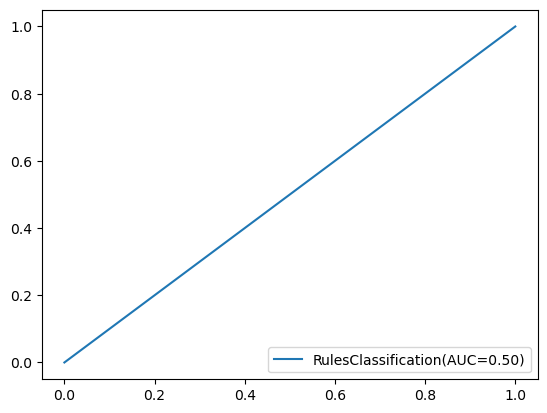

[2]
coverage: 0.7922077922077921


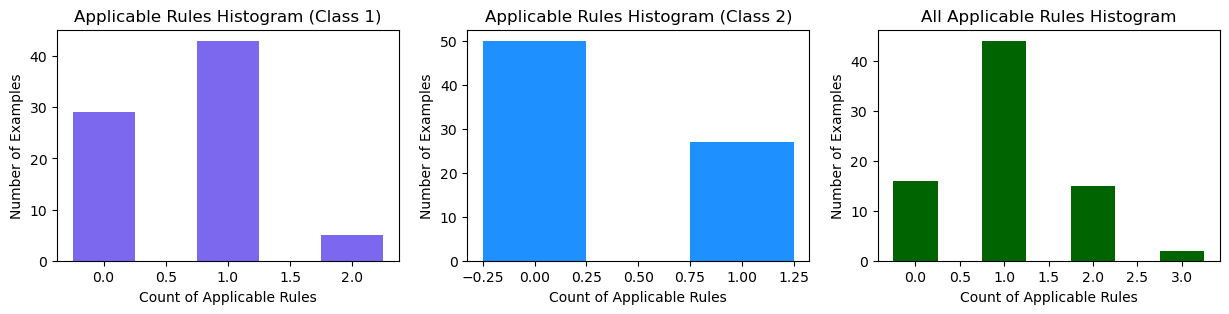

In [21]:
from rules_model import *

#eval_pred = predsList_eval #xgb_clf.predict(X_dev)
rules_model = RulesModel(ohe_df, discr_rules, y_eval, pos_label, neg_label)

test_pred = np.array(predsList_test)#
rules_test_sol = rules_model.eval_rules(df_X_test, test_pred, alpha=10, beta =1, decision_thr=0.97)